In [1]:
 #load Raw data from TDT ECoG maschine, plz run ""
import numpy as np
import scipy.io as scio
from scipy import signal
import tdt
import os
import  wave
import matplotlib.pyplot as plt
import json
from scipy.fftpack import fft
from random import shuffle
import h5py
import scipy.io as scio
import scipy.io.wavfile
import math
import mne
import os
from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor
import torch
from torch.utils import data as Data
import torch.nn as nn
import seaborn as sns
from ecog_band import EcogBandRes
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset,Dataset
from ecog_band.solver import Nfold_solver
from ecog_band.models import ECOGRes50_feature,ECOGRes50
from ecog_band.datasetSigband import CustomDatasetSigband
from ecog_band.utils import *


/root/pp/covert-reading/Ecog_pretrain/ecog_band/solver.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm  # may raise warning about Jupyter


In [2]:
bands_list=['else1','delta','theta','alpha','beta', 'gamma','high gamma','else2']
# bands_list=['gamma','high gamma']
HS=69
freq=500
elec=74

best_fold_model_path = f'/root/pp/covert-reading/Ecog_pretrain/best_models_resnet50/HS{HS}/{freq}/{elec}'
y_save_path = f'/root/pp/covert-reading/Ecog_pretrain/accuracy_reanet50_norm/HS{HS}/{freq}/{elec}'

os.makedirs(best_fold_model_path, exist_ok=True)
os.makedirs(y_save_path, exist_ok=True)

In [3]:
# five fold for each band
band_acc_list = {} # 存储每一个band的五次交叉验证最好的结果

for band_each in bands_list:
    path_elec=f'/public/DATA/overt_reading/dataset_/HS{HS}/{freq}/{elec}'
    num_samples=len(os.listdir(path_elec)) # 12
    # print(num_samples)
    data_loader = CustomDatasetSigband(HS, path_elec, freq, elec, num_samples, band_each)
    for batch in data_loader:
        print(batch[0].shape,batch[1]) #[1, 1, 375] 0    375=500*0.75
        break

    net=ECOGRes50_feature()

    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)

    solver = Nfold_solver(
        model = net,
        optimizer = optimizer,
        criterion = nn.BCEWithLogitsLoss(),
        lr_scheduler = lr_scheduler,
        )
    # print(net)

    fold_results, fold_all_labels, fold_all_preds = solver.train(
                epochs=100,
                data_loader=data_loader,
                band=band_each,
                best_fold_model_path=os.path.join(best_fold_model_path,str(elec))
                )
    band_acc_list[band_each] = fold_results # fold_results is a list, include 5 fold accuracy, every fold accuracy is the best accuracy in validate epochs
    # # plt confusion matrix
    # plt_confusion_matrix_sum(fold_all_labels, fold_all_preds, band_each)
    all_y_true = [label for sublist in fold_all_labels for label in sublist] # merge 5 list to one
    all_y_pred = [label for sublist in fold_all_preds for label in sublist] # merge 5 list to one
    np.save(os.path.join(y_save_path, f'{band_each}_y_pred.npy'), all_y_pred)
    np.save(os.path.join(y_save_path, f'{band_each}_y_true.npy'), all_y_true)

    # plt confusion matrix
    plt_confusion_matrix_sum(all_y_true, all_y_pred, band_each)
    
pltbox_band_five_cross_validation(band_acc_list)
# plt_band_acc(band_acc_list)

# write fold resultes into file
# save_path = f'/root/pp/covert-reading/Ecog_pretrain/fold_results/HS{HS}/{freq}/{elec}'
# save_band_classify_acc(band_acc_list, save_path)


torch.Size([1, 1, 375]) tensor(0)
Fold 1


[Train] Epoch 1/100:   0%|          | 0/576 [00:00<?, ?block/s]

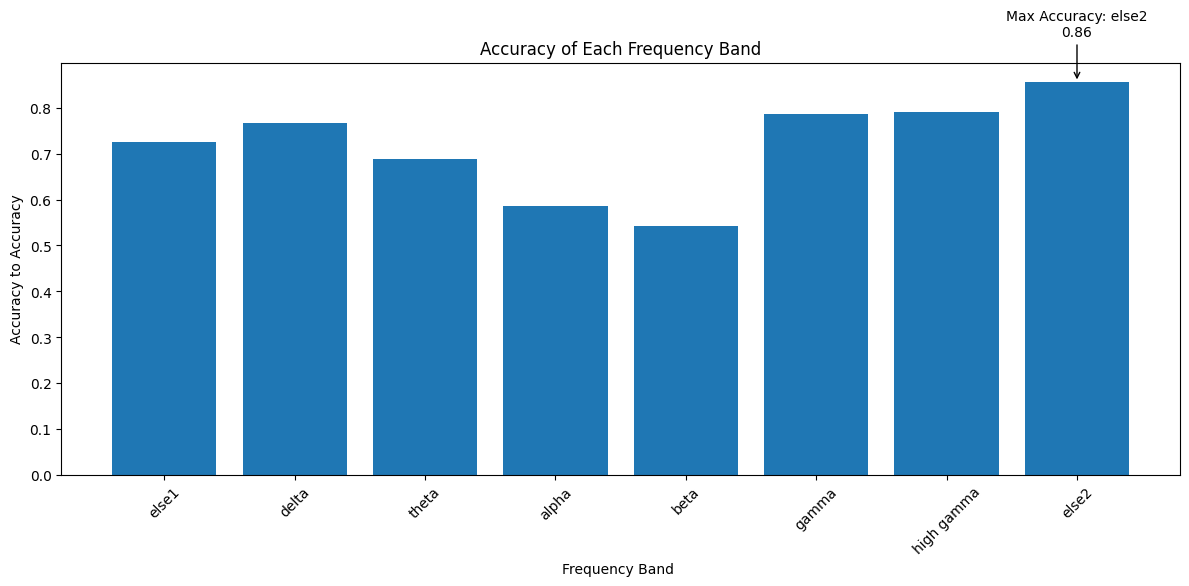

In [ ]:
# accuracy bar for each band
accuracy = []
for band in bands_list:
    accuracy.append(cal_acc_band1_from_y(y_save_path, band))
pltbar_accuracy(accuracy, bands_list)

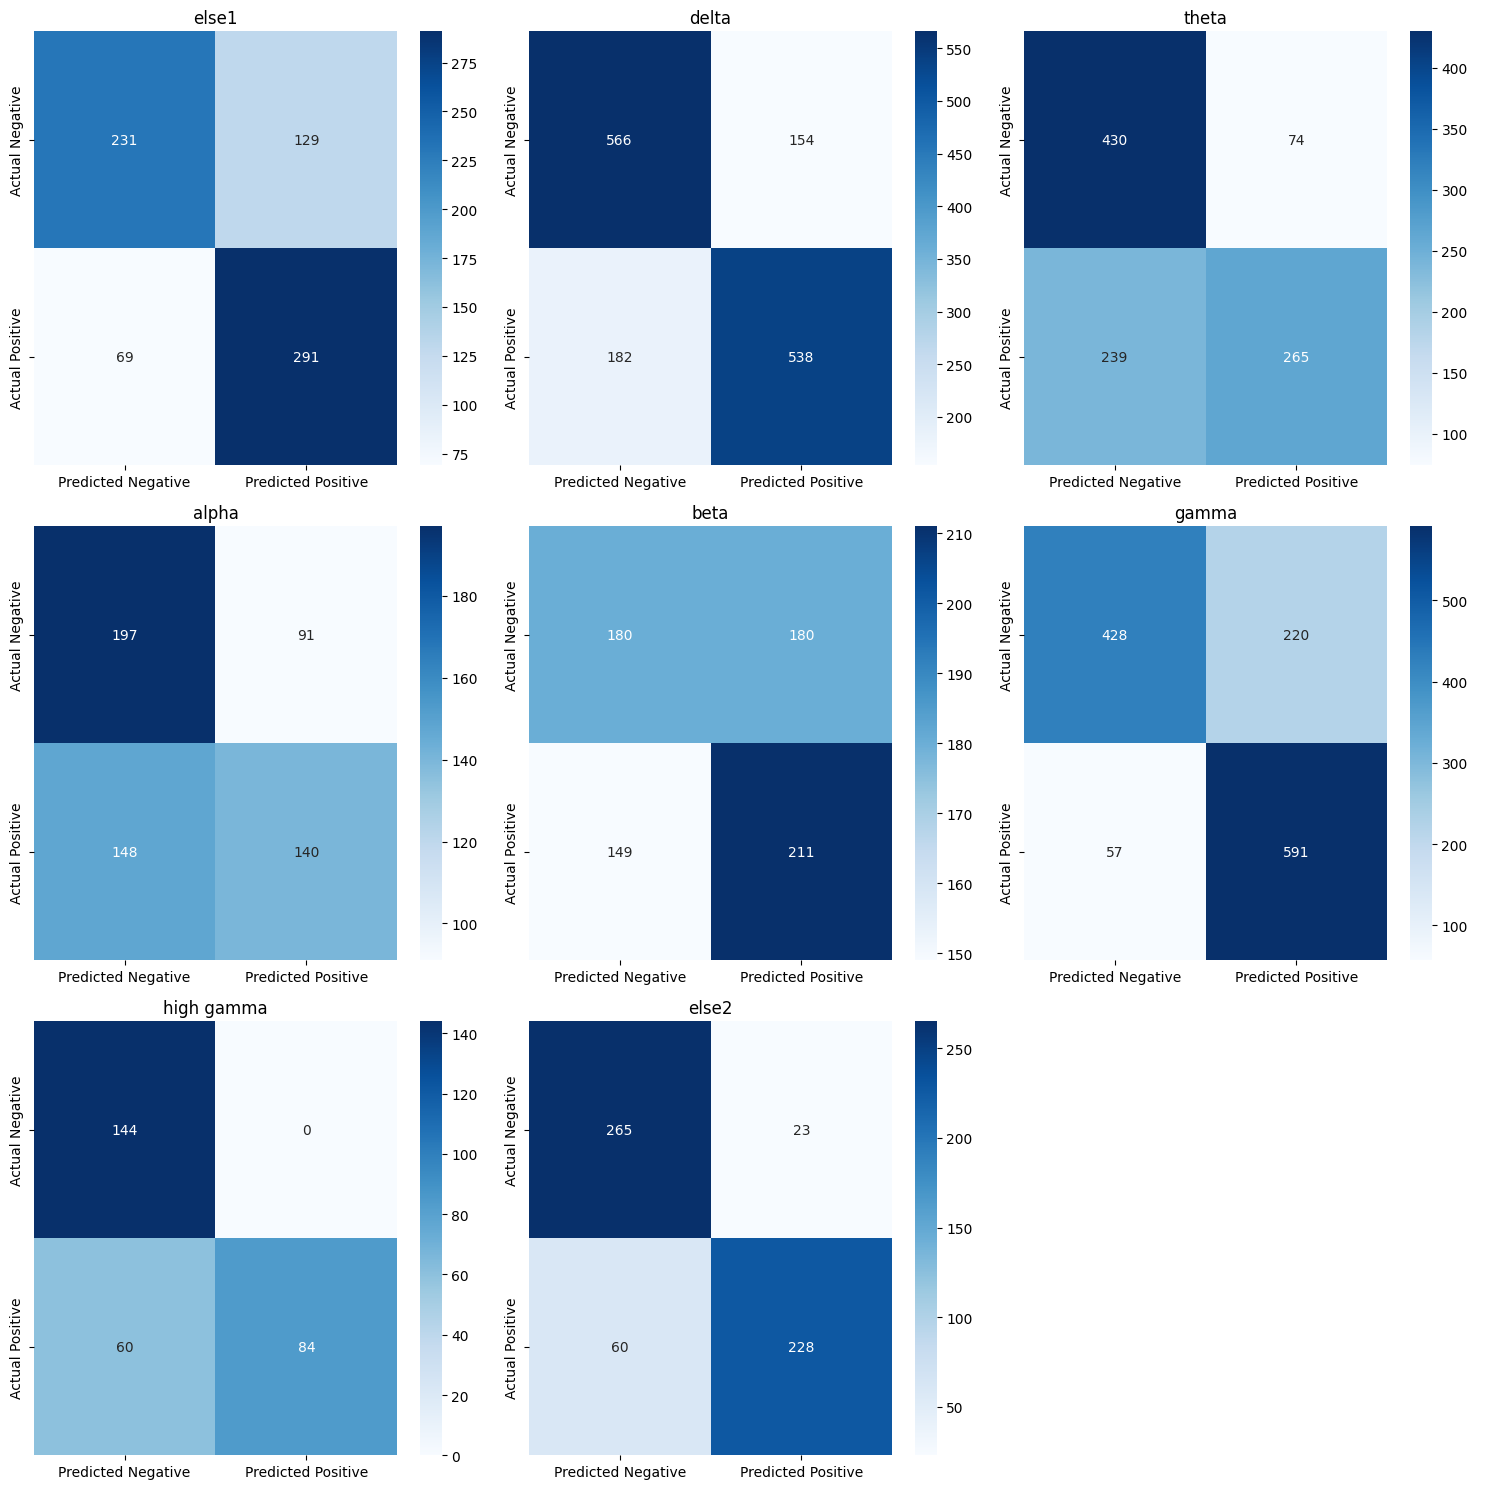

In [5]:
# show all matrix on one graph
cm = {}
for band in bands_list:
    cm[band] = cal_cm_band1_from_y(y_save_path, band)
plt_allband_confusion_matrices(cm, bands_list)